In [11]:
!pip install osmnx
!pip install pandas
!pip install folium
!pip install scikit-learn

In [12]:
import osmnx as ox
import pandas as pd
import folium
from sklearn.cluster import KMeans
from folium.plugins import HeatMap
from scipy.spatial import Voronoi
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.ops import unary_union

/var/folders/vz/b1smgzt13_dbs5c1rbj4m3dh0000gn/T/ipykernel_55740/3928065423.py:15: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bus_stops = ox.geometries_from_place(place_name, tags=tags_bus)


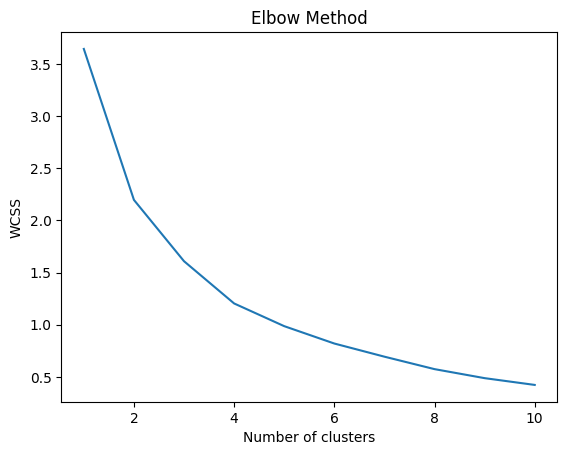

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
def is_bike_friendly(edge):
    bike_friendly_tags = ['yes', 'designated', 'permissive', 'lane', 'shared', 'shared_lane']
    bike_path_types = ['cycleway', 'path', 'living_street', 'residential']
    is_bike_tag_friendly = edge.get('bicycle') in bike_friendly_tags
    is_highway_type_friendly = edge.get('highway') in bike_path_types
    has_cycleway_infrastructure = ('cycleway' in edge) or ('cycleway:right' in edge) or ('cycleway:left' in edge)
    is_footway_bike_friendly = (edge.get('highway') in ['footway', 'pedestrian']) and edge.get('bicycle') == 'yes'
    return is_bike_tag_friendly or is_highway_type_friendly or has_cycleway_infrastructure or is_footway_bike_friendly

place_name = "Münster, Germany"
G = ox.graph_from_place(place_name, network_type='all')
df = pd.read_csv('filtered_data_munster.csv')

tags_bus = {'highway': 'bus_stop'}
bus_stops = ox.geometries_from_place(place_name, tags=tags_bus)

edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
bike_friendly_edges = edges[edges.apply(is_bike_friendly, axis=1)]

crs_proj = 'EPSG:32632'
bus_stops = bus_stops.to_crs(crs_proj)
bike_friendly_edges = bike_friendly_edges.to_crs(crs_proj)
nodes = ox.graph_to_gdfs(G, nodes=True, edges=False).to_crs(crs_proj)

bus_stops_buffer = bus_stops.buffer(20)
bike_friendly_buffer = bike_friendly_edges.buffer(20)

near_bus_stops = nodes[nodes.geometry.apply(lambda x: bus_stops_buffer.contains(x).any())]
near_bike_paths = nodes[nodes.geometry.apply(lambda x: bike_friendly_buffer.contains(x).any())]
near_both = near_bus_stops[near_bus_stops.index.isin(near_bike_paths.index)].to_crs('EPSG:4326')

df_near_both_coords = pd.DataFrame([(point.x, point.y) for point in near_both.geometry], columns=['Longitude', 'Latitude'])

# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_near_both_coords[['Longitude', 'Latitude']])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Select number of clusters based on Elbow Method
num_clusters = 1  # Set based on Elbow plot result

# K-Means Clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(df_near_both_coords[['Longitude', 'Latitude']])
near_both['Cluster'] = clusters

cluster_info = near_both.groupby('Cluster').agg({'geometry': 'count'}).rename(columns={'geometry': 'Count'})
max_count = cluster_info['Count'].max()
cluster_info['Normalized_Count'] = cluster_info['Count'] / max_count

map = folium.Map(location=[51.9625, 7.6256], zoom_start=13)

# Cluster visualization with interactive popups
for cluster_id, row in cluster_info.iterrows():
    cluster_center = kmeans.cluster_centers_[cluster_id]
    popup_text = f"Cluster: {cluster_id}\nCount: {row['Count']}"
    color = plt.cm.Reds(row['Normalized_Count'])
    color_hex = matplotlib.colors.to_hex(color)
    folium.Circle(
        location=[cluster_center[1], cluster_center[0]],
        radius=10 + row['Count'] * 1,
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.6,
        popup=popup_text
    ).add_to(map)

# Accident points visualization
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color='blue',
        fill=True
    ).add_to(map)

# Adding a HeatMap layer
heat_data = [[row['Latitude'], row['Longitude']] for _, row in df.iterrows()]
HeatMap(heat_data).add_to(map)

# Save and display the map
map.save('kmeans_zones_munster.html')
map